<a href="https://colab.research.google.com/github/JFaberSFSD/Healthcare_Predictions/blob/main/Predicting_Heart_Disease_Modeling_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#First thing first, let's grab our needed imports for our classification problem!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn import set_config
set_config(display='diagram')

#Now let's load our data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/07 - Week 7 (August 1st)/heart.csv')

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


#From our exploratory data analysis, we learned a few things about our features that required some cleaning, let's run through those quick to get our data ready for modeling

In [3]:
#Eliminate zero from 'RestingBP' as obviously zero isn't possible (there is only one row, so we will simply drop it)
df['RestingBP'] = df['RestingBP'].replace(0,np.nan)
df = df.dropna(subset=['RestingBP'])
df['RestingBP'].isna().sum()

0

In [4]:
#Change 'ExerciseAngina' to numeric: 0 for No and 1 for Yes
df['ExerciseAngina'] = df['ExerciseAngina'].replace({'N':0,'Y':1})
df['ExerciseAngina'].value_counts()

0    546
1    371
Name: ExerciseAngina, dtype: int64

#One last double-check for any duplicates

In [5]:
df.duplicated().sum()

0

#One last double-check for any missing values

In [6]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             917 non-null    int64  
 1   Sex             917 non-null    object 
 2   ChestPainType   917 non-null    object 
 3   RestingBP       917 non-null    float64
 4   Cholesterol     917 non-null    int64  
 5   FastingBS       917 non-null    int64  
 6   RestingECG      917 non-null    object 
 7   MaxHR           917 non-null    int64  
 8   ExerciseAngina  917 non-null    int64  
 9   Oldpeak         917 non-null    float64
 10  ST_Slope        917 non-null    object 
 11  HeartDisease    917 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 93.1+ KB


#Now that we have our data prepared, let's get to the fun part! The first step toward creating our models and tuning them is to do a train/test split to avoid any data leakage

In [8]:
X = df.drop(columns='HeartDisease')  
y = df['HeartDisease']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#We are going to try three different base models today, for our classification problem, so let's create instances of each.

#We will also need to scale our numerical data and encode our categorical data, so we will need both a scaler and one-hot-encoder

In [9]:
log_reg = LogisticRegression()
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state = 42)

scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

#Now let's create a preprocessing pipeline for our data, that will both scale our numerical data, and ohe our categorical data. Since our data does not contain any missing values, we do not have to instantiate an imputer of any kind.

In [10]:
#Let's create our column selectors for our different dytpes
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

#Each of our different dtypes will have to follow a different pipeline, so let's create one for each
numeric_pipe = make_pipeline(scaler)
categorical_pipe = make_pipeline(ohe)

#We will need a tuple, with our different piplines, to feed into our column transformer, let's make one for each dtypes now
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

#Finally we can create our preprocessor with both pipelines in it
preprocessor = make_column_transformer(number_tuple, category_tuple)

#With our preprocessor now ready to rock, let's start with our first model. We will just start at the top of our list with a logistic regression model with default parameters

In [11]:
log_pipe = make_pipeline(preprocessor, log_reg)

log_pipe.fit(X_train, y_train)

#Let's check default parameter scores
print(log_pipe.score(X_train, y_train))
print(log_pipe.score(X_test, y_test))

0.8617176128093159
0.8869565217391304


#Just under 89%! Not bad at all. Let's see if we can further improve this by tuning some hyper-parameters. Let's create a for-loop to run through different C-values. We will start with L1, and then test L2 after that

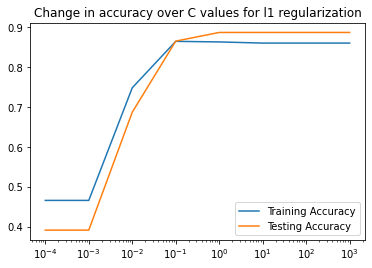

{0.0001: 0.391304347826087,
 0.001: 0.391304347826087,
 0.01: 0.6869565217391305,
 0.1: 0.8652173913043478,
 1: 0.8869565217391304,
 10: 0.8869565217391304,
 100: 0.8869565217391304,
 1000: 0.8869565217391304}

In [12]:
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []


for c in c_values:
  log_reg_2 = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l1')
  log_reg_2_pipe = make_pipeline(preprocessor, log_reg_2)
  log_reg_2_pipe.fit(X_train, y_train)
 
  train_scores.append(log_reg_2_pipe.score(X_train, y_train))
  test_scores.append(log_reg_2_pipe.score(X_test, y_test))
 

fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l1 regularization')
ax.legend()
ax.set_xscale('log')
plt.show()

{c:score for c, score in zip(c_values, test_scores)}

#It looks like L1 regularization caps out at 88.695% with any C value at 1 or above. This is the same score as our default model, so let's check L2 regularization instead

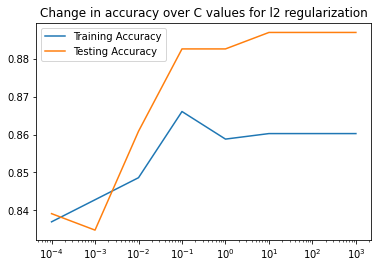

{0.0001: 0.8391304347826087,
 0.001: 0.8347826086956521,
 0.01: 0.8608695652173913,
 0.1: 0.8826086956521739,
 1: 0.8826086956521739,
 10: 0.8869565217391304,
 100: 0.8869565217391304,
 1000: 0.8869565217391304}

In [13]:
l2_train_scores = []
l2_test_scores = []


for c in c_values:
  log_reg_3 = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l2')
  log_reg_3_pipe = make_pipeline(preprocessor, log_reg_3)
  log_reg_3_pipe.fit(X_train, y_train)
 
  l2_train_scores.append(log_reg_3_pipe.score(X_train, y_train))
  l2_test_scores.append(log_reg_3_pipe.score(X_test, y_test))
 

fig2, ax2 = plt.subplots(1,1)
ax2.plot(c_values, l2_train_scores, label='Training Accuracy')
ax2.plot(c_values, l2_test_scores, label='Testing Accuracy')
ax2.set_xticks(c_values)
ax2.set_title('Change in accuracy over C values for l2 regularization')
ax2.legend()
ax2.set_xscale('log')
plt.show()

{c:score for c, score in zip(c_values, l2_test_scores)}

#Well you can't win every time! Once again, no value of C for L2 can improve upon our base model accuracy of 88.695. For now we will just move forward with our base model. Let's run all metrics on it this time through so that we can see precision, recall, etc.

              precision    recall  f1-score   support

           0       0.83      0.90      0.86        90
           1       0.93      0.88      0.90       140

    accuracy                           0.89       230
   macro avg       0.88      0.89      0.88       230
weighted avg       0.89      0.89      0.89       230

0.8617176128093159
0.8869565217391304


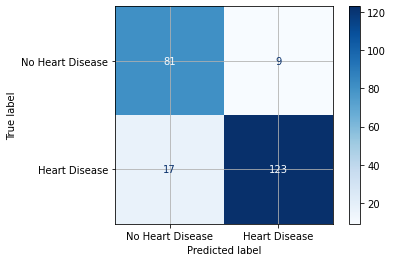

In [14]:
log_final = LogisticRegression()

log_pipe_final = make_pipeline(preprocessor, log_final)

log_pipe_final.fit(X_train, y_train)

log_preds = log_pipe_final.predict(X_test)

labels=['No Heart Disease','Heart Disease']
ConfusionMatrixDisplay.from_predictions(y_test, log_preds, display_labels=labels, cmap='Blues')
plt.grid(None)


knn_report = classification_report(y_test, log_preds)
print(knn_report)

print(log_pipe_final.score(X_train, y_train))
print(log_pipe_final.score(X_test, y_test))

##As we can see from our Metrics, our model has an overall accuracy on our test data of 88.695%. We can also see that we have a precision on our positive class of 93% and a recall of 88%. These are both fairly solid. We only had 9 total false positives, but on the flip side we had 17 false negatives. Because of the nature of what we're modeling (predicting heart disease), it's in our best intersest to limit the total number of false negatives that our model creates, so let's explore other models to see if we can maintain or improve on our accuracy, while minimizing false negatives!

#The next model we will run will be a KNN model. We will start again with default parameters, and we can use the same preprocessor we've already created within our pipeline.

In [15]:
knn_pipe = make_pipeline(preprocessor, knn)

knn_pipe.fit(X_train, y_train)

#Let's check KNN default scores
print(knn_pipe.score(X_train, y_train))
print(knn_pipe.score(X_test, y_test))

0.87627365356623
0.8739130434782608


#Our KNN model is starting off a touch below our logistic regression model, but let's use GridSearchCV to see if we can tune some hyper-parameters to improve our model. We can see which hyper-parameters are available for tuning by running a 'get_params' on our pipeline.

In [16]:
knn_pipe.get_params()

#From this, let's target the following: n_neighbors, p, weight, and leaf_size

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f9eeafc28d0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f9eeafc2c10>)])),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('pipeline-1',
                                  Pipeline(steps=[('standardscaler',
    

In [17]:
knn_param_grid = {'kneighborsclassifier__n_neighbors': range(1,10),
                  'kneighborsclassifier__p': range(1,5),
                  'kneighborsclassifier__weights': ['distance','uniform'],
                  'kneighborsclassifier__leaf_size' : [10,20,30,40,50]}


knn_pipe_gs = GridSearchCV(knn_pipe, knn_param_grid)

knn_pipe_gs.fit(X_train, y_train)

knn_pipe_gs.best_params_

{'kneighborsclassifier__leaf_size': 10,
 'kneighborsclassifier__n_neighbors': 9,
 'kneighborsclassifier__p': 1,
 'kneighborsclassifier__weights': 'distance'}

#The ideal leaf_size was at the bottom of our tested range, let's tweak our range lower for that parameter and test one more time

In [ ]:
knn_param_grid = {'kneighborsclassifier__n_neighbors': range(1,10),
                  'kneighborsclassifier__p': range(1,5),
                  'kneighborsclassifier__weights': ['distance','uniform'],
                  'kneighborsclassifier__leaf_size' : [2,4,6,8,10]}


knn_pipe_gs = GridSearchCV(knn_pipe, knn_param_grid)

knn_pipe_gs.fit(X_train, y_train)

knn_pipe_gs.best_params_

{'kneighborsclassifier__leaf_size': 2,
 'kneighborsclassifier__n_neighbors': 9,
 'kneighborsclassifier__p': 1,
 'kneighborsclassifier__weights': 'distance'}

#With our best hyper-parameters now identified, let's create a final KNN model, and run full metrics on it with a classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        90
           1       0.93      0.90      0.91       140

    accuracy                           0.90       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.90      0.90      0.90       230

1.0
0.8956521739130435


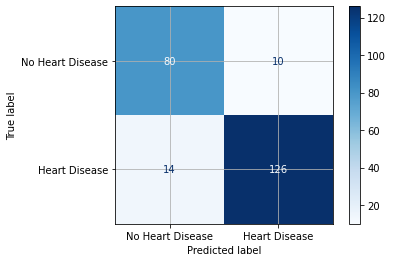

In [ ]:
knn_final = KNeighborsClassifier(n_neighbors=9, p=1, weights='distance', leaf_size = 2)

knn_pipe_final = make_pipeline(preprocessor, knn_final)

knn_pipe_final.fit(X_train, y_train)

knn_preds = knn_pipe_final.predict(X_test)

labels=['No Heart Disease','Heart Disease']
ConfusionMatrixDisplay.from_predictions(y_test, knn_preds, display_labels=labels, cmap='Blues')
plt.grid(None)


knn_report = classification_report(y_test, knn_preds)
print(knn_report)

print(knn_pipe_final.score(X_train, y_train))
print(knn_pipe_final.score(X_test, y_test))

#Overall accuaracy of 89.565%. Not a huge improvement, but still it should also be noted, that we maintained our positive class precision of 93%, while improving our recall to 90%. We can see from the confusion matrix that our KNN model had 14 false negatives, compared to the 17 false negatives we had in our logistic regression model. Not huge moves, but we are moving in the right direction!

#For our last model, let's try a random forest model to see if we can make any final improvements!

In [ ]:
rf_pipe = make_pipeline(preprocessor, rf)

rf_pipe.fit(X_train, y_train)

#Let's check initial rf scores
print(rf_pipe.score(X_train, y_train))
print(rf_pipe.score(X_test, y_test))

1.0
0.8913043478260869


##A promising start! Over 89% with just the base model! Let's once again run GridSearch to see if we can hyper-tune our model

In [ ]:
#Let's check our parameters that we can tune
rf_pipe.get_params()

#Based on this, let's set up GridSearchCV to check for best options on 'max_depth', 'min_samples_leaf', 'min_samples_split', and 'n_estimators'

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f21ea0fa210>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f21ea0fa9d0>)])),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('pipeline-1',
                                  Pipeline(steps=[('st

In [ ]:
#Let's make sure we at least start with the value for depth as what our default model found:

est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

21

In [ ]:
rf_param_grid = {'randomforestclassifier__max_depth': [15,21,25], 
              'randomforestclassifier__min_samples_leaf': [1,5,10], 
              'randomforestclassifier__min_samples_split': [2,10,20],
              'randomforestclassifier__n_estimators': [10,25,100,200]}


rf_grid_search = GridSearchCV(rf_pipe, rf_param_grid)

rf_grid_search.fit(X_train, y_train)   

rf_grid_search.best_params_

{'randomforestclassifier__max_depth': 21,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 10,
 'randomforestclassifier__n_estimators': 25}

##Alright, we're zeroing in on the best parameters. Now that we have a better idea of the general ranges, let's try one more time with ranges closer to our ideals. 

In [ ]:
final_param_grid = {'randomforestclassifier__max_depth': [17,18,19,20,21,22], 
              'randomforestclassifier__min_samples_leaf': [1,2], 
              'randomforestclassifier__min_samples_split': [8,10,12],
              'randomforestclassifier__n_estimators': [15,25,35]}


rf_grid_search_final = GridSearchCV(rf_pipe, final_param_grid)

rf_grid_search_final.fit(X_train, y_train)   

rf_grid_search_final.best_params_

{'randomforestclassifier__max_depth': 17,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 10,
 'randomforestclassifier__n_estimators': 25}

##Looks like we've got our hyperparameters! Let's create a final random forest model with these and once again run our metrics.

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        90
           1       0.91      0.91      0.91       140

    accuracy                           0.89       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.89      0.89      0.89       230

0.9330422125181951
0.8869565217391304


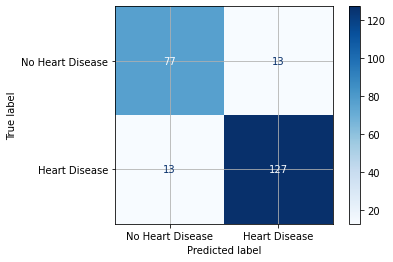

In [ ]:
rf_final = RandomForestClassifier(max_depth = 17, min_samples_leaf = 1, min_samples_split = 10, n_estimators = 25, random_state=42)

rf_pipe_final = make_pipeline(preprocessor, rf_final)

rf_pipe_final.fit(X_train, y_train)

rf_preds = rf_pipe_final.predict(X_test)

labels=['No Heart Disease','Heart Disease']
ConfusionMatrixDisplay.from_predictions(y_test, rf_preds, display_labels=labels, cmap='Blues')
plt.grid(None)


rf_report = classification_report(y_test, rf_preds)
print(rf_report)

print(rf_pipe_final.score(X_train, y_train))
print(rf_pipe_final.score(X_test, y_test))

##Looks like slighly lower than KNN in overall accuracy at 88.695% again. We did see a slight increase in recall to 91%, resulting in 13 false negatives, but with the side-effect of a lower precision % and 3 additional false positives. Not sure that's the best trade-off. Looking at our three models, our best overall appears to be the KNN Model. Let's move forward with this model as our official selection, but there's still a little more we can do!

#Let's check to see if PCA can help bump our results up a little bit

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        90
           1       0.93      0.90      0.91       140

    accuracy                           0.90       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.90      0.90      0.90       230

1.0
0.8956521739130435


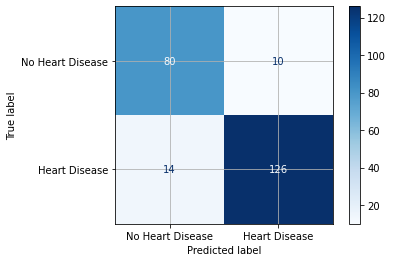

In [ ]:
#First instantiate a PCA. Since we aren't looking to lower the number of features in our data, we will just keep everything to default value
pca = PCA()

#Now we can create a pipeline with our original preprocessor, along with PCA
PCA_preprocessor = make_pipeline(preprocessor, pca)

#Finally we can make our modeling pipeline with KNN, making sure to include our previously identified hyper-parameters
knn_PCA = KNeighborsClassifier(n_neighbors=9, p=1, weights='distance', leaf_size = 2)
knn_pca_pipe = make_pipeline(PCA_preprocessor, knn_PCA)
knn_pca_pipe.fit(X_train, y_train)

knn_pca_preds = knn_pca_pipe.predict(X_test)

labels=['No Heart Disease','Heart Disease']
ConfusionMatrixDisplay.from_predictions(y_test, knn_pca_preds, display_labels=labels, cmap='Blues')
plt.grid(None)


knn_pca_report = classification_report(y_test, knn_pca_preds)
print(knn_pca_report)

print(knn_pca_pipe.score(X_train, y_train))
print(knn_pca_pipe.score(X_test, y_test))

##Well it was worth a shot! But PCA did not influence our results at all.

##Another idea to try is gradient boosting. Let's see if we can still possibly reach that magic 90% number!

In [ ]:
gbc = GradientBoostingClassifier()
gbc_pipe = make_pipeline(preprocessor, gbc)
gbc_pipe.fit(X_train, y_train)

print('GBC Training accuracy:', gbc_pipe.score(X_train, y_train))
print('GBC Testing accuracy:', gbc_pipe.score(X_test, y_test))

GBC Training accuracy: 0.9577874818049491
GBC Testing accuracy: 0.8739130434782608


In [ ]:
lgbm = LGBMClassifier()
lgbm_pipe = make_pipeline(preprocessor, lgbm)
lgbm_pipe.fit(X_train, y_train)

print('LGBM Training accuracy:', lgbm_pipe.score(X_train, y_train))
print('LGBM Testing accuracy:', lgbm_pipe.score(X_test, y_test))

LGBM Training accuracy: 1.0
LGBM Testing accuracy: 0.8739130434782608


In [ ]:
xgb = XGBClassifier()
xgb_pipe = make_pipeline(preprocessor, xgb)
xgb_pipe.fit(X_train, y_train)

print('XGB Training accuracy:', xgb_pipe.score(X_train, y_train))
print('XGB Testing accuracy:', xgb_pipe.score(X_test, y_test))

XGB Training accuracy: 0.9417758369723436
XGB Testing accuracy: 0.8782608695652174


##It doesn't appear that gradient boosting is going to be the answer, none of the models performed better than our hyper-tuned KNN model. 

##When the dust settles, it looks like our best option for moving forward is going to be our hyper-tuned KNN model. It runs at an accuracy of just under 90%, with solid precision (93%) and most importantly a solid recall (90%) resulting in limited false-negatives. Overall still a very solid model!